In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
sns.set_style("darkgrid")

import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression as LR

from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', -1)  

In [3]:
df = pd.read_csv('Clean_data.csv', index_col=0)

df.drop(index = range(215, 274), inplace= True)
df.drop(columns=['Prop'], inplace= True)
df.head()

Oil     Total   P1   P2   P3   P4   P5          P6
274  1.133333  1.700000  0.0  0.0  0.0  0.0  0.0  651.875000
275  1.000000  1.548387  0.0  0.0  0.0  0.0  0.0  653.333333
276  1.400000  2.000000  0.0  0.0  0.0  0.0  0.0  543.120000
277  1.250000  1.821429  0.0  0.0  0.0  0.0  0.0  556.666667
278  1.193548  1.741935  0.0  0.0  0.0  0.0  0.0  547.868852

In [4]:
# AR() Error 
def AR_Er(data_X, data_Y, p = 0):
    
    X = np.matrix(data_X)
    Y = np.array(data_Y)
    m = X.shape[1] # Amount of predictors
    n = X.shape[0] # Amount of observations

    LR_Init = LR().fit(X, Y) # Initial Linear model
    b_free = LR_Init.intercept_
    b_coef = LR_Init.coef_.copy()
    Predict = LR_Init.predict(X) 
    b_coef_new = np.zeros(m)+1e9
    b_free_new = 1e9
    
    Resid = Y - Predict
    if p==0:
        p = AR_Order(Resid)
    
    while((abs(b_free_new-b_free)>0.001)| np.all((abs(b_coef_new-b_coef)>0.001))):
        b_coef = b_coef_new.copy()
        b_free = b_free_new

        AR_Res = sm.tsa.ARIMA(Resid.transpose(), order=(p,0,0)).fit(full_output=False, disp=0)
        
        phi = AR_Res.params[1:].copy()
        beta = AR_Res.params[0]
        
        Y_Cohr = Y[p:].copy()
        for j in range(p):
            Y_Cohr = Y_Cohr - phi[j]*Y[p-(j+1):n-(j+1)] 
        
        X_Cohr = X[p:, :].copy()
        
        for i in range(m):
            for j in range(p):
                X_Cohr[0:, i] = X_Cohr[0:, i]-phi[j]*X[p-(j+1):n-(j+1),i]
            
        LR_Optim = LR().fit(X_Cohr, Y_Cohr)

        b_coef_new = LR_Optim.coef_.copy()
        b_free_new = LR_Optim.intercept_/(1-phi.sum())
        
        
        Predict = np.array(b_coef_new*X.transpose() + b_free_new)[0]
        Resid = Y - Predict
        
    New_Predict = np.zeros(n)
    
    for i in range(p):
        New_Predict[i] = Predict[i]
    for i in range(p,n):
        New_Predict[i] = Predict[i]
        for j in range(p):
            New_Predict[i] = New_Predict[i]+phi[j]*(Y[i-1-j]-Predict[i-1-j])
            
    return New_Predict, p, b_free_new, b_coef_new


In [5]:
# Check pacf and acf of residuals
def ARMA_Check(data_X, data_Y):
    X = np.matrix(data_X)
    Y = np.array(data_Y)
    LR_Regular = LR().fit(X, Y) # Initial Linear model
    
    Predict = LR_Regular.predict(X) 
    Resid = Y - Predict
    pl_acf = plot_acf(Resid)
    pl_pacf = plot_pacf(Resid)
    
    plt.rcParams["figure.figsize"] =(18,4)
    plt.show()

In [6]:
# Return AR order of error
def AR_Order(Resid):
    Order = 1
    while((pacf(Resid)>1/np.sqrt(len(Resid)))[Order]):
        Order+=1
    return Order-1

In [7]:

def OneCommonLag(l, use_df=df, show_ARMA = False, p=0):
    if l == 0:
        P_lag = np.array(use_df.iloc[:,2:])
    else:
        P_lag = np.array(use_df.iloc[:-l,2:])
    if show_ARMA:
        ARMA_Check(P_lag, use_df.Oil[l:])
    return AR_Er(P_lag, use_df.Oil[l:], p)

def TwoCommonLag(l, show_ARMA = False, p=0):
    max_l = max(l)
    size = len(df.iloc[:,2:8])
    P2_lag = np.array(pd.concat([df.iloc[max_l-l[0]:size-l[0],2:8].reset_index(drop=True),
                                df.iloc[max_l-l[1]:size-l[1],2:8].reset_index(drop=True)], axis=1))
    if show_ARMA:
        ARMA_Check(P2_lag, df.Oil[max_l:])
    return AR_Er(P2_lag, df.Oil[max_l:], p)

def SeparateLag(i, j, show_ARMA = False, p=0):
    PI_lag = np.array(pd.concat([df.iloc[j:,2:(2+i)].reset_index(drop=True),
                                 df.iloc[:-j,(2+i)].reset_index(drop=True),
                                df.iloc[j:,(3+i):8].reset_index(drop=True)], axis=1))
    
    if show_ARMA:
        ARMA_Check(PI_lag, df.Oil[j:])
    return AR_Er(PI_lag, df.Oil[j:], p)

def GradientLag(l, show_ARMA = False, p=0):
    max_l = max(l)
    size = len(df.Oil)
    PG_lag = np.array(pd.concat([df.iloc[(max_l-l[0]):(size-l[0]),2].reset_index(drop=True),
                                 df.iloc[(max_l-l[1]):(size-l[1]),3].reset_index(drop=True),
                                 df.iloc[(max_l-l[2]):(size-l[2]),4].reset_index(drop=True),
                                 df.iloc[(max_l-l[3]):(size-l[3]),5].reset_index(drop=True),
                                 df.iloc[(max_l-l[4]):(size-l[4]),6].reset_index(drop=True),
                                 df.iloc[(max_l-l[5]):(size-l[5]),7].reset_index(drop=True)], axis=1))
    if show_ARMA:
        ARMA_Check(PG_lag, df.Oil[max_l:])
    return AR_Er(PG_lag, df.Oil[max_l:], p)


### Пусть ошибка регрессии имеет AR структуру
Одномерная ситуация при первом включении 6 насоса

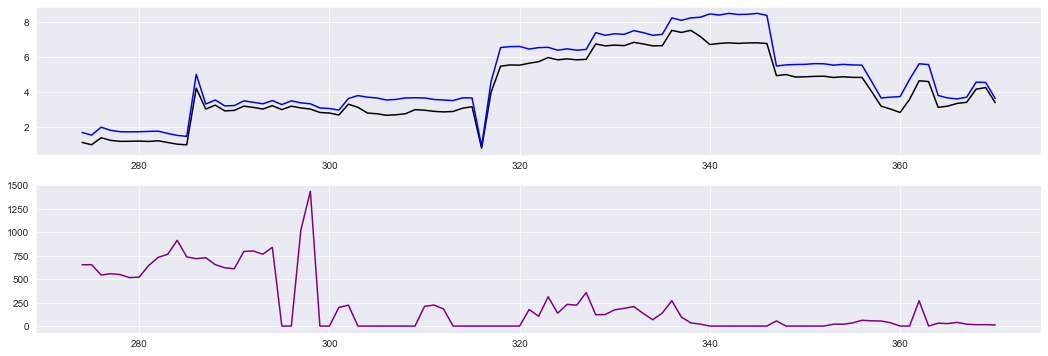

In [8]:
df6 = df.loc[274:370].copy()

plt.rcParams["figure.figsize"] =(18,6)
df6 = df6.drop(columns = ['P1', 'P2', 'P3', 'P4', 'P5'])

fig, ax = plt.subplots(nrows = 2, ncols =1)
ax[0].plot(df6.index, df6.Oil, color = 'black', label = 'Oil')
ax[0].plot(df6.index, df6.Total, color = 'blue', label = 'Total')
ax[1].plot(df6.index, df6.P6, color = 'purple', label = 'P6')
plt.show()


Text(0.5, 1.0, 'Oil to time')

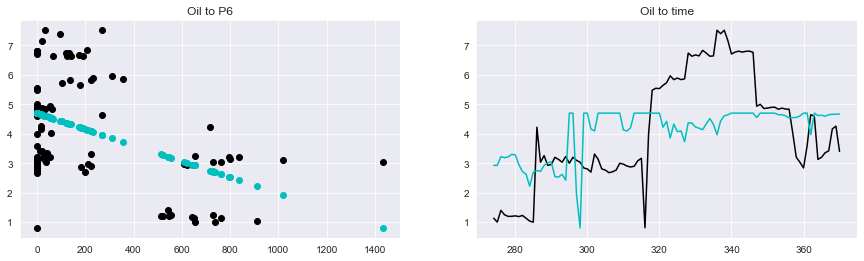

In [9]:
Y_Oil = pd.DataFrame(df6.Oil)
X_P6 = pd.DataFrame(df6.P6)
LR_P6 = LR().fit(X_P6, Y_Oil)
b1 = LR_P6.coef_[0]
b0 = LR_P6.intercept_

df6['Predict'] = LR_P6.predict(X_P6)
df6['Resid'] = df6['Oil'] - df6['Predict']

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
plt.subplots_adjust(hspace=0.4)
ax[0].plot(df6.P6, df6.Oil, 'ko')
ax[0].plot(df6.P6, df6.Predict, 'co')
ax[0].set_title('Oil to P6')
ax[1].plot(df6.index, df6.Oil, 'k')
ax[1].plot(df6.index, df6.Predict, 'c')
ax[1].set_title('Oil to time')

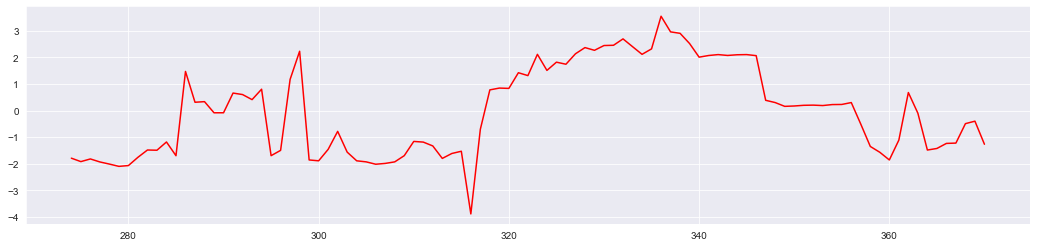

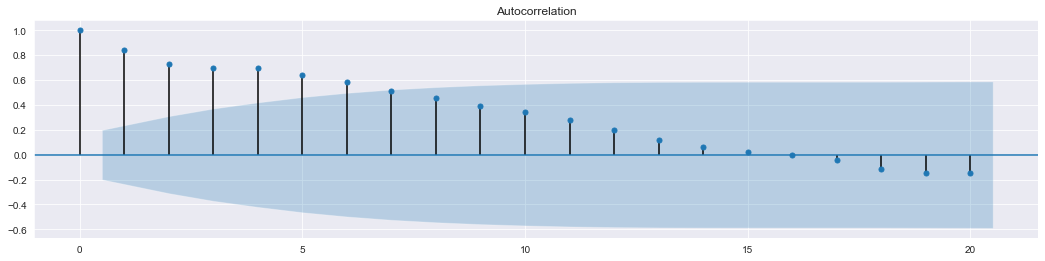

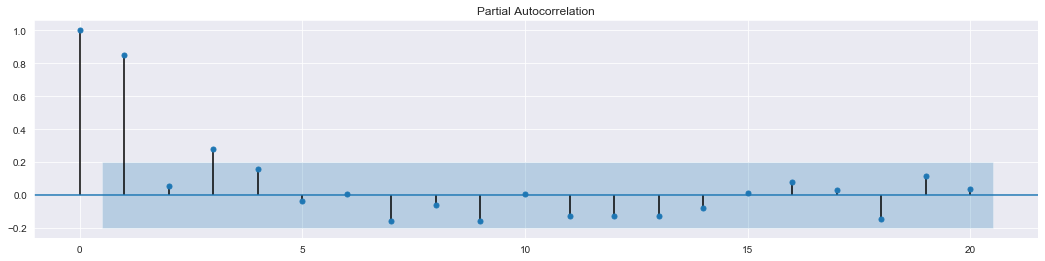

In [10]:
plt.rcParams["figure.figsize"] =(18,4)
plt.plot(df6.index, df6.Resid, 'r')

acf_P6 = plot_acf(df6.Resid)
pacf_P6 = plot_pacf(df6.Resid)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:215: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



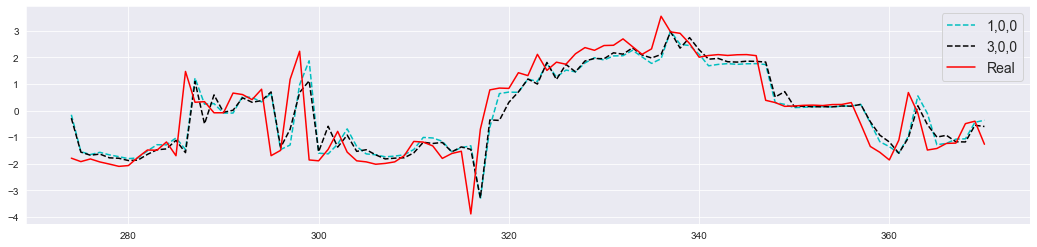

                              ARMA Model Results                              
Dep. Variable:                  Resid   No. Observations:                   97
Model:                     ARMA(1, 0)   Log Likelihood                -125.849
Method:                       css-mle   S.D. of innovations              0.880
Date:                Fri, 20 Dec 2019   AIC                            257.698
Time:                        11:46:57   BIC                            265.422
Sample:                             0   HQIC                           260.822
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.1602      0.566     -0.283      0.778      -1.269       0.949
ar.L1.Resid     0.8498      0.052     16.297      0.000       0.748       0.952
                                    Roots       

In [11]:
AR_P6 = sm.tsa.ARIMA(df6.Resid, order=(1,0,0)).fit(full_output=False, disp=0)
AR_P6_2 = sm.tsa.ARIMA(df6.Resid, order=(3,0,0)).fit(full_output=False, disp=0)
plt.plot(AR_P6.predict(), 'c--', label = '1,0,0')
plt.plot(AR_P6_2.predict(), 'k--', label = '3,0,0')
plt.plot(df6.Resid, 'red', label = 'Real')
plt.legend(fontsize = 14)
plt.show()
print(AR_P6.summary())

---- AR Error (1)
Mean squared error: 0.5439
Variance score: 0.8449
[0.0001063]


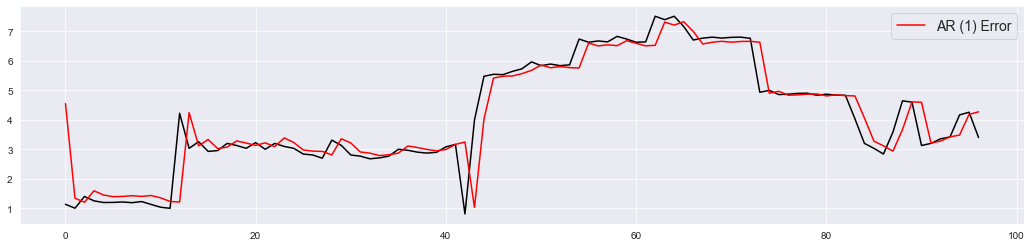

Overall usage of water, period between 370th and 520th days:
 Oil      397.103362  
Total    461.874217  
P6       21661.764646
dtype: float64


In [12]:
df6 = df.loc[274:370].copy()
df6 = df6.drop(columns = ['P1', 'P2', 'P3', 'P4', 'P5'])
plt.rcParams["figure.figsize"] =(18,4)

PredictP6_NoL, AR_used, b_free, b_coef = OneCommonLag(0, df6) 
print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(df6.Oil, PredictP6_NoL.transpose()))
print('Variance score: %.4f' % r2_score(df6.Oil, PredictP6_NoL.transpose()))
print(b_coef)
plt.plot(np.array(df6.Oil), color = 'black')
plt.plot(PredictP6_NoL.transpose(), color = 'red', label = 'AR (' + str(AR_used) + ') Error')
plt.legend(fontsize = 14)
plt.show()

print("Overall usage of water, period between 370th and 520th days:\n", df6.sum(axis = 0))

### Пусть ошибка регрессии имеет AR структуру
Multivariate case, separated by first turn

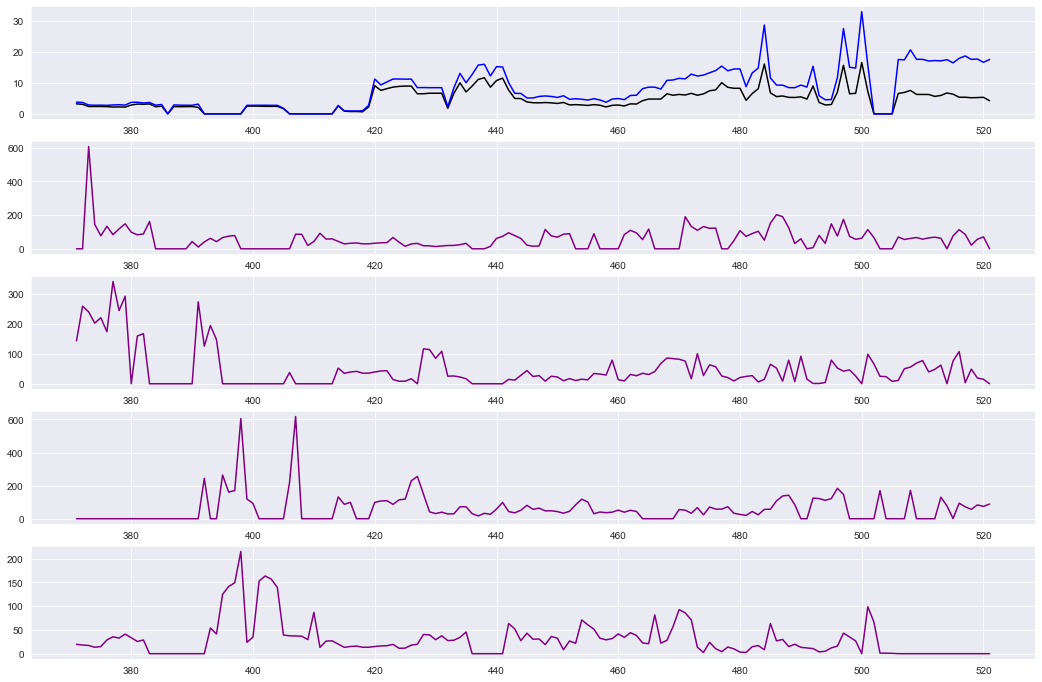

In [13]:
#Turning on 3rd, 4th, 5th, 6th pump

dfP3_6 = df.loc[371:521].copy()
dfP3_6  = dfP3_6.drop(columns = ['P1', 'P2'])

fig, ax = plt.subplots(nrows = 5, ncols =1, figsize = (18,12))
ax[0].plot(dfP3_6.index, dfP3_6.Oil, color = 'black')
ax[0].plot(dfP3_6.index, dfP3_6.Total, color = 'blue')
ax[1].plot(dfP3_6.index, dfP3_6.P3, color = 'purple')
ax[2].plot(dfP3_6.index, dfP3_6.P4, color = 'purple')
ax[3].plot(dfP3_6.index, dfP3_6.P5, color = 'purple')
ax[4].plot(dfP3_6.index, dfP3_6.P6, color = 'purple')


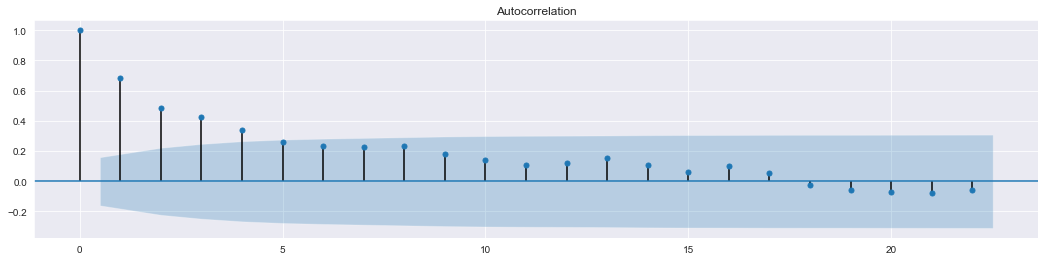

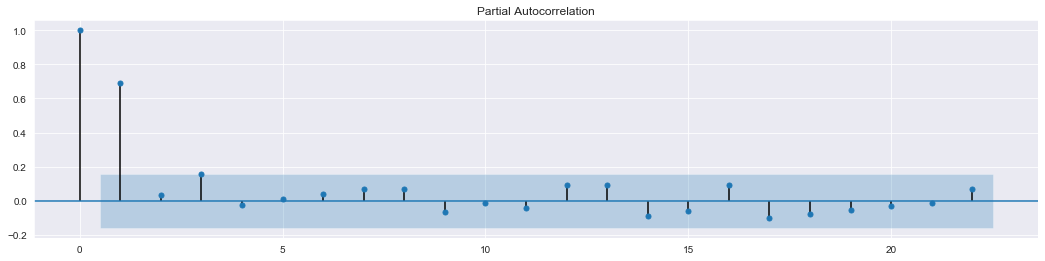

---- AR Error (1)
Mean squared error: 4.9996
Variance score: 0.5511
Coefficients: [ 0.00018063 -0.00236402  0.00184373 -0.0162969 ]
Free: 5.074742074978535


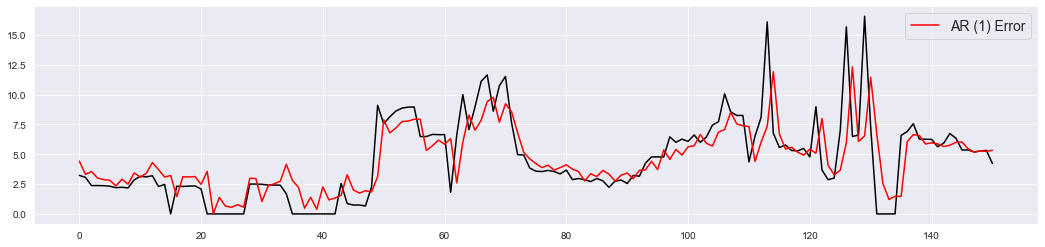

Overall usage of water, period between 370th and 520th days:
 Oil      692.838209 
Total    1209.298833
P3       8546.893884
P4       7092.745444
P5       8892.094046
P6       4478.978762
dtype: float64


In [14]:

plt.rcParams["figure.figsize"] =(18,4)
PredictP3_6_NoL, AR_used, b_free, b_coef = OneCommonLag(0, dfP3_6, True) 


print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(dfP3_6.Oil, PredictP3_6_NoL.transpose()))
print('Variance score: %.4f' % r2_score(dfP3_6.Oil, PredictP3_6_NoL.transpose()))
print('Coefficients:', b_coef)
print('Free:',b_free)

plt.plot(np.array(dfP3_6.Oil), color = 'black')
plt.plot(PredictP3_6_NoL.transpose(), color = 'red', label = 'AR (' + str(AR_used) + ') Error')
plt.legend(fontsize = 14)
plt.show()
print("Overall usage of water, period between 370th and 520th days:\n", dfP3_6.sum(axis = 0))

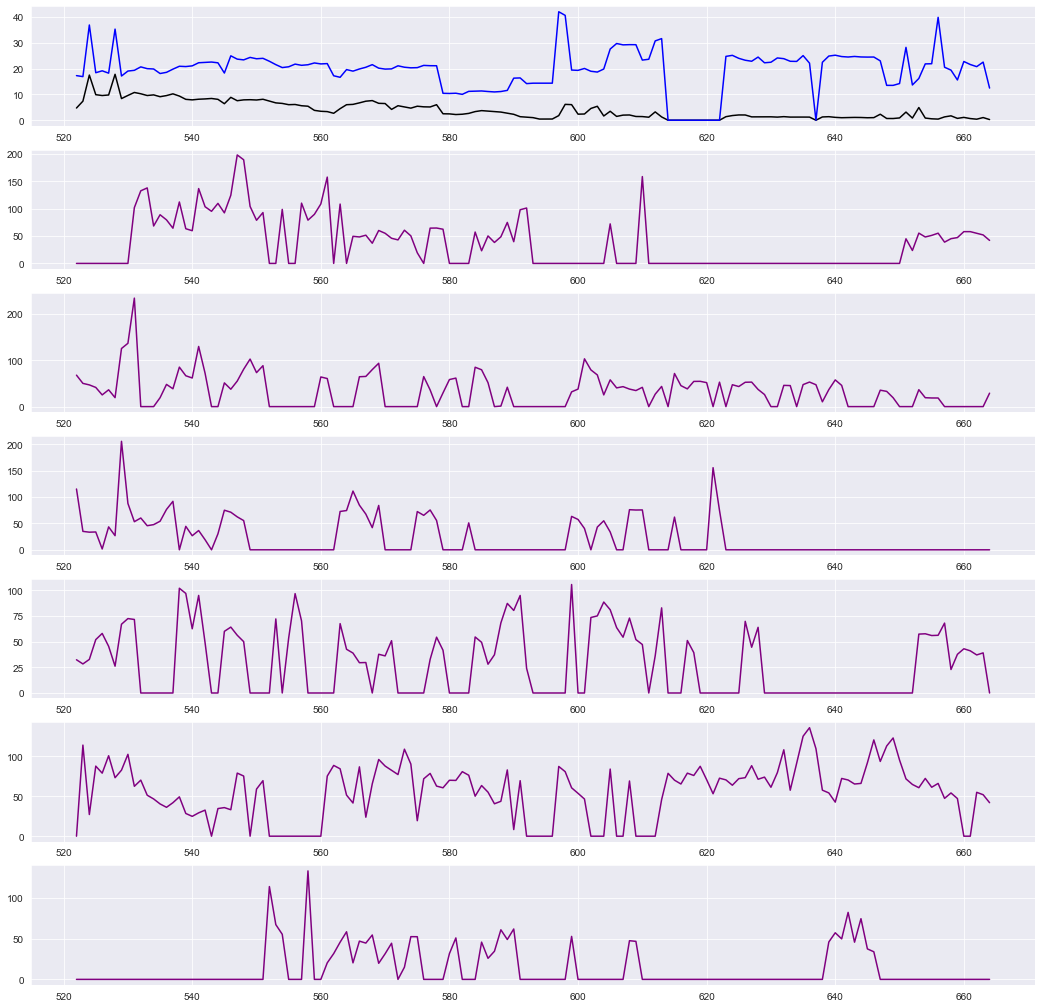

In [15]:
#Turning on 1st and 2nd pump (3rd, 4th, 5th, 6th are still working)

dfP_All = df.loc[522:].copy()

fig, ax = plt.subplots(nrows = 7, ncols =1, figsize = (18,18))
ax[0].plot(dfP_All.index, dfP_All.Oil, color = 'black')
ax[0].plot(dfP_All.index, dfP_All.Total, color = 'blue')
ax[1].plot(dfP_All.index, dfP_All.P1, color = 'purple')
ax[2].plot(dfP_All.index, dfP_All.P2, color = 'purple')
ax[3].plot(dfP_All.index, dfP_All.P3, color = 'purple')
ax[4].plot(dfP_All.index, dfP_All.P4, color = 'purple')
ax[5].plot(dfP_All.index, dfP_All.P5, color = 'purple')
ax[6].plot(dfP_All.index, dfP_All.P6, color = 'purple')

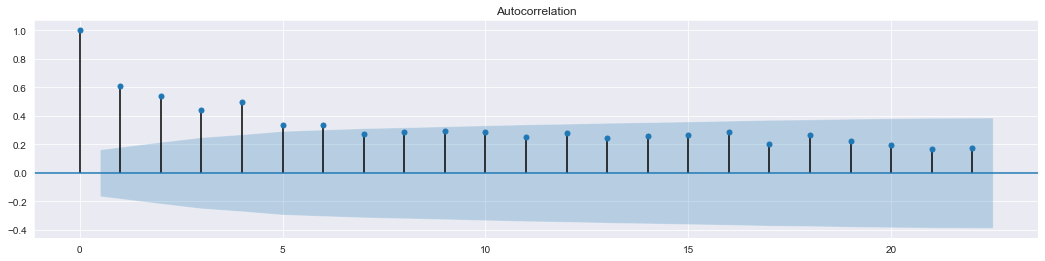

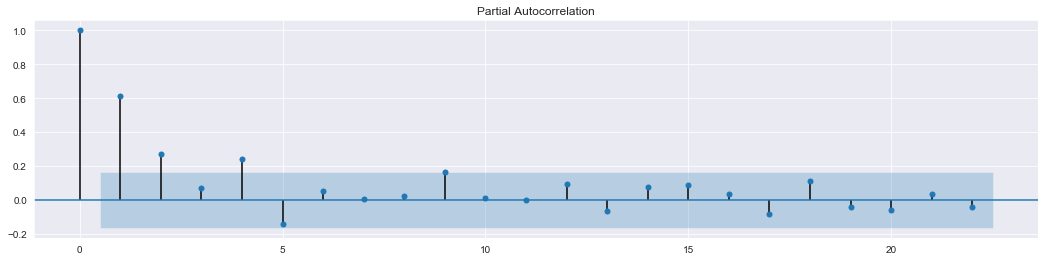

---- AR Error (2)
Mean squared error: 2.9147
Variance score: 0.7641
[ 0.00549663 -0.00190453 -0.00845666  0.00415248 -0.01142574  0.00492537]
Free: 3.7702917789223758


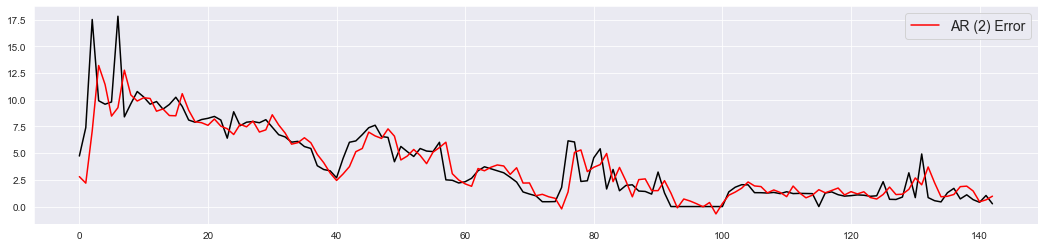

Overall usage of water, period between 370th and 520th days:
 Oil      566.243888 
Total    2795.843420
P1       5131.768598
P2       4631.262209
P3       3099.141400
P4       4011.776726
P5       7863.937601
P6       1840.628454
dtype: float64


In [16]:
plt.rcParams["figure.figsize"] =(18,4)
PredictP_All_NoL, AR_used, b_free, b_coef = OneCommonLag(0, dfP_All, True) 

print("---- AR Error (%.0f)" %(AR_used))
print("Mean squared error: %.4f" % mean_squared_error(dfP_All.Oil, PredictP_All_NoL.transpose()))
print('Variance score: %.4f' % r2_score(dfP_All.Oil, PredictP_All_NoL.transpose()))
print(b_coef)

print('Free:',b_free)
plt.plot(np.array(dfP_All.Oil), color = 'black')
plt.plot(PredictP_All_NoL.transpose(), color = 'red', label = 'AR (' + str(AR_used) + ') Error')
plt.legend(fontsize = 14)
plt.show()

print("Overall usage of water, period between 370th and 520th days:\n", dfP_All.sum(axis = 0))

In [17]:
Complete_predict = np.hstack((PredictP6_NoL, PredictP3_6_NoL,PredictP_All_NoL))

print("Mean squared error: %.2f" % mean_squared_error(df.Oil, Complete_predict.transpose()))
print('Variance score: %.2f' % r2_score(df.Oil, Complete_predict.transpose()))

Mean squared error: 3.13
Variance score: 0.68


In [21]:
import chart_studio.plotly as py
import plotly.graph_objects as go



fig = go.Figure()
fig.add_trace(go.Scatter(x= df.index, y= df.Oil, mode= 'lines+markers', opacity = 0.9, 
                 name = 'Oil', marker=dict(color='Black', size=5)))

fig.add_trace(go.Scatter(x= df6.index, y= PredictP6_NoL, mode= 'lines', opacity = 0.9, 
                 name = 'P 6', marker=dict(color='Green', size=5)))

fig.add_trace(go.Scatter(x= dfP3_6.index,y=  PredictP3_6_NoL, mode= 'lines', opacity = 0.9,
                  name = 'P 3-6', marker=dict(color='blue', size=5)))

fig.add_trace(go.Scatter(x= dfP_All.index, y= PredictP_All_NoL, mode= 'lines', opacity = 0.9,
                   name = 'P All', marker=dict(color='darkorange', size=5)))

fig.update_layout(    
    legend_orientation="h",
        
    showlegend=False,
    font=dict(
            family="sans-serif",
            size=16,
            color="black"
        ),
    width=1920,
    height=680, 

    plot_bgcolor='rgba(240, 240, 240, 0.7)'
    )
fig.show()

py.iplot([Oil, P6, P3_6, PAll])